<h1><center><strong> X-Ray Body Parts Prediction </center></strong></h1> 

Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

2023-08-20 15:57:24.330974: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-20 15:57:24.332467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-20 15:57:24.363452: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-20 15:57:24.364406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 15:57:25.003633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'data')
IMAGES_DIR = os.path.join(BASE_DIR, 'data', 'images_train')
TRAIN_PATH = os.path.join(DATA_DIR, 'images_train')

In [3]:
# load train_df and test_df csv into a dataframe
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_df.csv'))

train_df.head(2)

,Unnamed: 0,Instance,Target
0,0,1.2.826.0.1.3680043.8.498.13143567732829440604...,[0]
1,1,1.2.826.0.1.3680043.8.498.41966468661924231037...,[0]


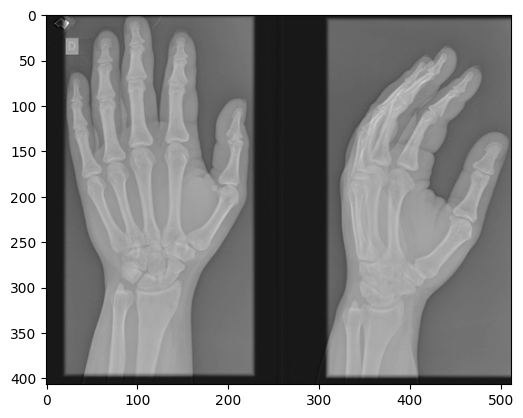

In [4]:
# displaying a sample image index 7 in df row
image = plt.imread(os.path.join(TRAIN_PATH, 'hand', '1.2.826.0.1.3680043.8.498.10223562747252542050013124843498019558-c.png'))
plt.imshow(image, cmap='gray')

In [5]:
# check for multi-label images
train_df['Target'] = train_df['Target'].apply(lambda x: [int(label.strip("[]")) for label in x.split(",")])
for idx, label in enumerate(train_df['Target']):
    if len(label) > 1:
        print(idx, label, len(label))

In [6]:
# identify multi labels images so they can be used while training with respect to their labels
#multi_label_images = []
#for i, val in enumerate(train_df.Target):
#    if len(val) > 1:
#        multi_label_images.append((os.path.join(TRAIN_PATH, train_df.loc[i].SOPInstanceUID + '-c.png'), train_df.loc[i].Target))

IndexError: list index out of range

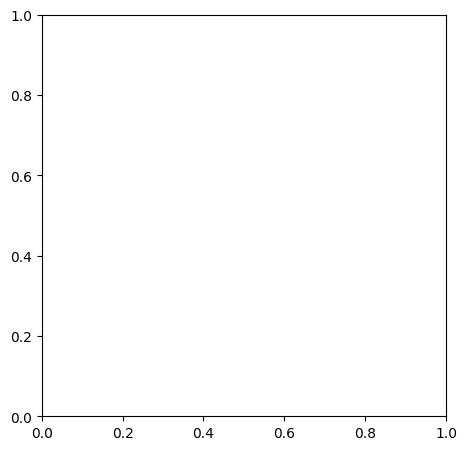

In [8]:
# function to plot images on a figure
plt.figure(figsize=(24, 24))
for i in range(10):
    plt.subplot(4,4,i+1)
    img = plt.imread(multi_label_images[i][0])
    plt.imshow(img, cmap='gray')


cv2.normalize() process modifies the intensity values of pixels in a given image to make the image more appealing. It can be used for 
- Contrast Enhancement using norm_tye=cv2.cv2.NORM_MINMAX
- Machine Learning for scaling the pixel values between 0 to 1 to help neural network to converge faster
- Comparison and Visualization can make it easier to compare images and identify patterns or anomalies
- Preprocessing for Algorithms for edge detection allows algorithim to detect eges consistently across different images
The scaled image might look similar to the original image, but with adjusted brightness and contrast based on the chosen normalization method (alpha, beta, and norm_type). For example, a grayscale image that appears too dark might be scaled to increase the brightness, making the image more visible.

Formula: 
dst = (src - min(src)) * (beta - alpha) / (max(src) - min(src)) + alpha

dst: This represents the output array where the normalized pixel values will be stored.
src: This is the input array, which contains the original pixel values of the image that you want to normalize.
min(src): This is the minimum value of the src array, i.e., the minimum pixel value in the image.
max(src): This is the maximum value of the src array, i.e., the maximum pixel value in the image.
alpha: This is the offset parameter, and it determines the value that will be added to the normalized pixel values after scaling.
beta: This is the scaling parameter, and it determines the value that will be multiplied with the normalized pixel values after subtracting min(src).

Alpha (off-set) (lower-bound): 
This is the offset parameter, and it determines the value that will be added to the normalized pixel values after scaling. It is often used to set the lower bound of the output range. If alpha is set to 0, it means there is no offset, and the normalized values will start from 0. Increasing alpha will shift the normalized values upwards.

Beta (Scaling) (upper-bound): 
This is the scaling parameter, and it determines the value that will be multiplied with the normalized pixel values after subtracting min(src). It is often used to set the upper bound of the output range. If beta is set to 1, it means there is no scaling, and the normalized values will remain within the range determined by alpha. Increasing beta will stretch the normalized values.

norm_type:
cv2.NORM_MINMAX: This method scales and shifts the pixel values to the specified range [alpha, beta]. The formula for normalization is dst = (src - min(src)) * (beta - alpha) / (max(src) - min(src)) + alpha, where src is the input array.


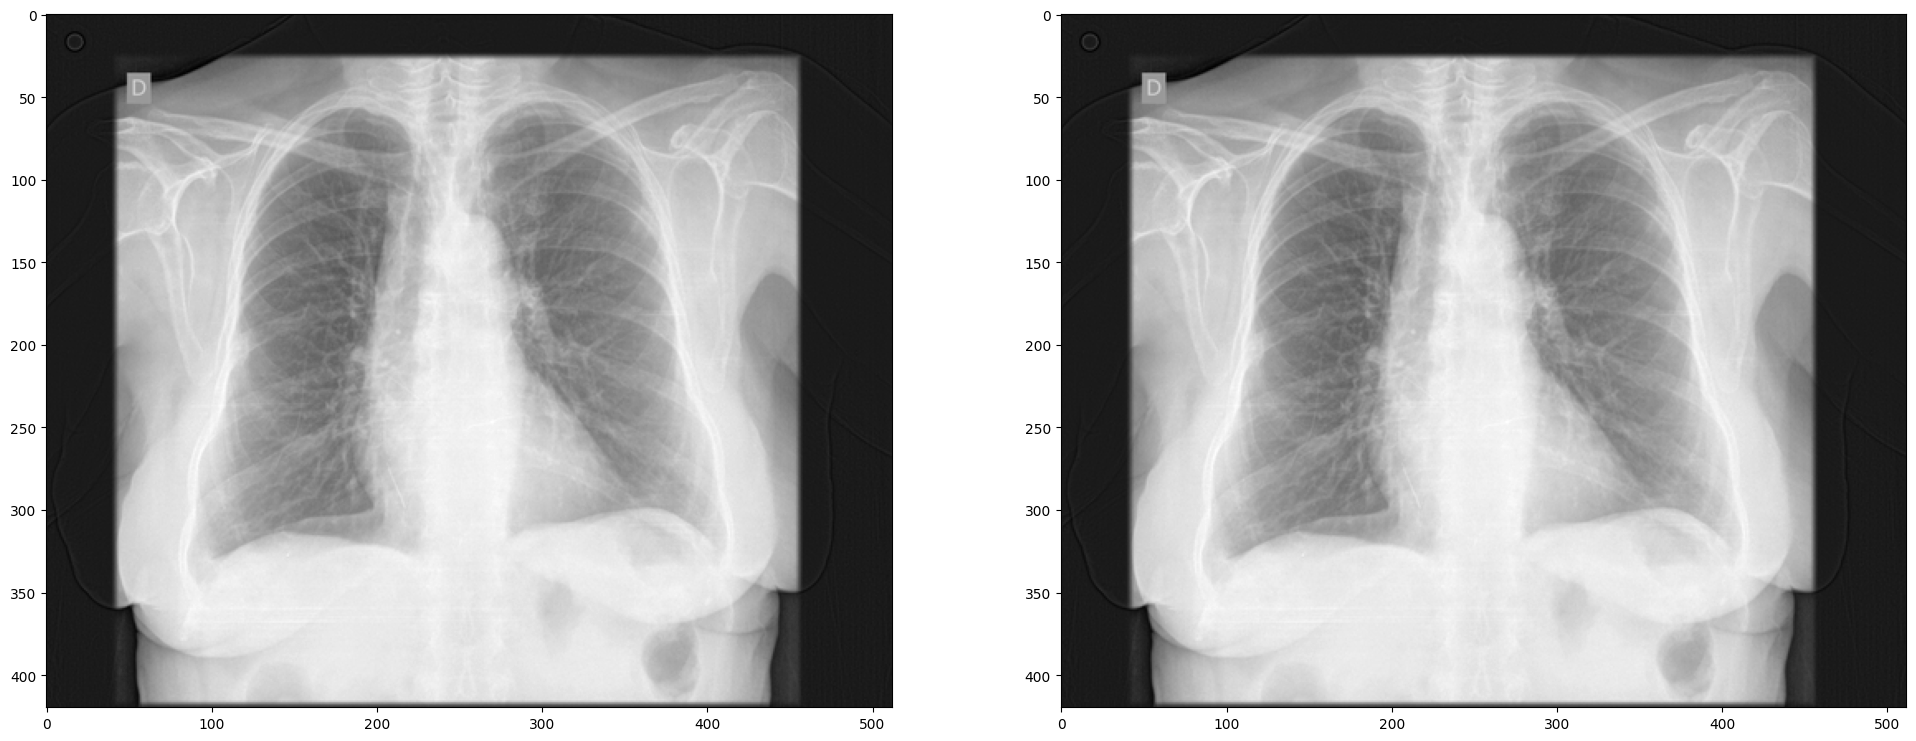

In [ ]:
# compare original with normalized image 
plt.figure(figsize=(24,24))
img = plt.imread(os.path.join(os.getcwd(), 'data', 'image_png.png'))
norm_img = cv2.normalize(img, None, alpha=0, beta=500, norm_type=cv2.NORM_MINMAX)
plt.subplot(2, 2, 1)
plt.imshow(norm_img, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(img, cmap='gray')

In [ ]:
# create a df 'train_dff' and extract required series
train_dff = pd.DataFrame()
train_dff['SOPInstanceUID'] = train_df['SOPInstanceUID']
train_dff['Target'] = train_df['Target']
train_dff.head(41)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0]
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15]
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12]
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,[14]
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,[3]
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,[3]
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,[14]
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,"[13, 20]"
8,1.2.826.0.1.3680043.8.498.10072001800484199846...,[3]
9,1.2.826.0.1.3680043.8.498.10077219503857952412...,[3]


In [ ]:
def labels(label):
    if label == 0:
        return 'Abdomen'
    elif label == 1:
        return 'Ankle'
    elif label == 2:
        return 'Cervical Spine'
    elif label == 3:
        return 'Chest'
    elif label == 4:
        return 'Clavicles'
    elif label == 5:
        return 'Elbow'
    elif label == 6:
        return 'Feet'
    elif label == 7:
        return 'Finger'
    elif label == 8:
        return 'Forearm'
    elif label == 9:
        return 'Hand'
    elif label == 10:
        return 'Hip'
    elif label == 11:
        return 'Knee'
    elif label == 12:
        return 'Lower Leg'
    elif label == 13:
        return 'Lumbar Spine'
    elif label == 14:
        return 'Others'
    elif label == 15:
        return 'Pelvis'
    elif label == 16:
        return 'Shoulder'
    elif label == 17:
        return 'Sinus'
    elif label == 18:
        return 'Skull'
    elif label == 19:
        return 'Thigh'
    elif label == 20:
        return 'Thoracic Spine'
    elif label == 21:
        return 'Wrist'
    
def label_to_int(label):
    label_map = {
        'Abdomen': 0,
        'Ankle': 1,
        'Cervical Spine': 2,
        'Chest': 3,
        'Clavicles': 4,
        'Elbow': 5,
        'Feet': 6,
        'Finger': 7,
        'Forearm': 8,
        'Hand': 9,
        'Hip': 10,
        'Knee': 11,
        'Lower Leg': 12,
        'Lumbar Spine': 13,
        'Others': 14,
        'Pelvis': 15,
        'Shoulder': 16,
        'Sinus': 17,
        'Skull': 18,
        'Thigh': 19,
        'Thoracic Spine': 20,
        'Wrist': 21
    }
    return label_map[label]


In [ ]:
train_dff['Target'].head(15)

0          [0]
1         [15]
2         [12]
3         [14]
4          [3]
5          [3]
6         [14]
7     [13, 20]
8          [3]
9          [3]
10         [3]
11        [14]
12         [3]
13         [3]
14         [5]
Name: Target, dtype: object

In [ ]:
# creating a new series 'Labels' with str representation of labels
train_dff['Labels'] = train_dff['Target'].apply(lambda x: ', '.join([labels(int(l)) for l in x]))

In [ ]:
train_dff.head(50)

,SOPInstanceUID,Target,Labels
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0],Abdomen
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15],Pelvis
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12],Lower Leg
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,[14],Others
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,[3],Chest
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,[3],Chest
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,[14],Others
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,"[13, 20]","Lumbar Spine, Thoracic Spine"
8,1.2.826.0.1.3680043.8.498.10072001800484199846...,[3],Chest
9,1.2.826.0.1.3680043.8.498.10077219503857952412...,[3],Chest


In [ ]:
# get_dummies creates new columns for each category present in the row.
train_dff = pd.get_dummies(train_dff['Labels'])

In [ ]:
train_dff.head(10)
train_dff['SOPInstanceUID'] = train_df['SOPInstanceUID']
train_dff['Target'] = train_df['Target']
train_dff.head(3)

,Abdomen,"Abdomen, Chest","Abdomen, Pelvis",Ankle,"Ankle, Feet","Ankle, Knee, Lower Leg","Ankle, Lower Leg",Cervical Spine,"Cervical Spine, Lumbar Spine, Thoracic Spine","Cervical Spine, Thoracic Spine",...,Pelvis,"Pelvis, Thigh",Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist,SOPInstanceUID,Target
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0]
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15]
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12]


In [ ]:
new_train_df = pd.merge(train_df, train_dff, on='SOPInstanceUID')
new_train_df.head()

,SOPInstanceUID,Target_x,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,StudyDate,SeriesDate,...,Others,Pelvis,"Pelvis, Thigh",Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist,Target_y
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,[0],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,[0]
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,[15],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,True,False,False,False,False,False,False,False,[15]
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,[12],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,[12]
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,[14],NaN,NaN,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,True,False,False,False,False,False,False,False,False,[14]
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,[3],1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,False,False,False,False,False,False,False,False,False,[3]


In [ ]:
new_train_df.drop('Target_y', axis=1, inplace=True)

In [ ]:
new_train_df.columns[65:]

Index(['Abdomen', 'Abdomen, Chest', 'Abdomen, Pelvis', 'Ankle', 'Ankle, Feet',
       'Ankle, Knee, Lower Leg', 'Ankle, Lower Leg', 'Cervical Spine',
       'Cervical Spine, Lumbar Spine, Thoracic Spine',
       'Cervical Spine, Thoracic Spine', 'Chest', 'Chest, Feet',
       'Chest, Finger', 'Chest, Pelvis', 'Clavicles', 'Elbow',
       'Elbow, Forearm', 'Feet', 'Finger', 'Finger, Hand', 'Forearm',
       'Forearm, Shoulder', 'Hand', 'Hand, Wrist', 'Hip', 'Hip, Knee, Thigh',
       'Hip, Thigh', 'Knee', 'Knee, Lower Leg', 'Lower Leg', 'Lumbar Spine',
       'Lumbar Spine, Thoracic Spine', 'Others', 'Pelvis', 'Pelvis, Thigh',
       'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic Spine', 'Wrist'],
      dtype='object')

Images have different sizes we need to standardize them to (128, 128) pixels for this we will use cv2.resize()

In [ ]:
X_images = []
Y_labels = []

In [ ]:

for i, val in enumerate(new_train_df.SOPInstanceUID):
    SOPInstance = val
    image_path = os.path.join(train_path, val + '-c.png')
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(img, dsize=(128, 128))
    img_norm = cv2.normalize(img_resize, None, alpha=0, beta=500, norm_type=cv2.NORM_MINMAX)
    # var 'X' will contain the array representation of orginal image and we add a new dimention to the array at start
    X_images.append(np.expand_dims(img_resize, axis=-1))
    # flatten img_norm into 1d array and store it in list var 'Y'
    Y_labels.append(np.ndarray.flatten(np.array(new_train_df.loc[i][new_train_df.columns[65:]])))

X_images = np.array(X_images)
Y_labels = np.array(Y_labels)

In [ ]:
coloumn_idx = 65
for idx, label in enumerate(new_train_df.columns[65:]):
    data_size = new_train_df.iloc[:, coloumn_idx].sum()
    label_list = [l.strip() for l in label.split(',')]
    int_labels = [label_to_int(l) for l in label_list]
    
    print(idx, data_size, int_labels)

    # # increment column
    coloumn_idx += 1



0 80 [0]
1 11 [0, 3]
2 1 [0, 15]
3 41 [1]
4 7 [1, 6]
5 5 [1, 11, 12]
6 1 [1, 12]
7 77 [2]
8 3 [2, 13, 20]
9 1 [2, 20]
10 724 [3]
11 1 [3, 6]
12 1 [3, 7]
13 1 [3, 15]
14 9 [4]
15 23 [5]
16 2 [5, 8]
17 70 [6]
18 15 [7]
19 1 [7, 9]
20 12 [8]
21 1 [8, 16]
22 31 [9]
23 42 [9, 21]
24 19 [10]
25 2 [10, 11, 19]
26 4 [10, 19]
27 102 [11]
28 1 [11, 12]
29 19 [12]
30 39 [13]
31 45 [13, 20]
32 120 [14]
33 67 [15]
34 2 [15, 19]
35 40 [16]
36 23 [17]
37 10 [18]
38 7 [19]
39 15 [20]
40 63 [21]


In [ ]:
# Checking the labels
# return the max value along the row (in this case the max value is a boolean 'true')
X_images[0].shape

(128, 128, 1)

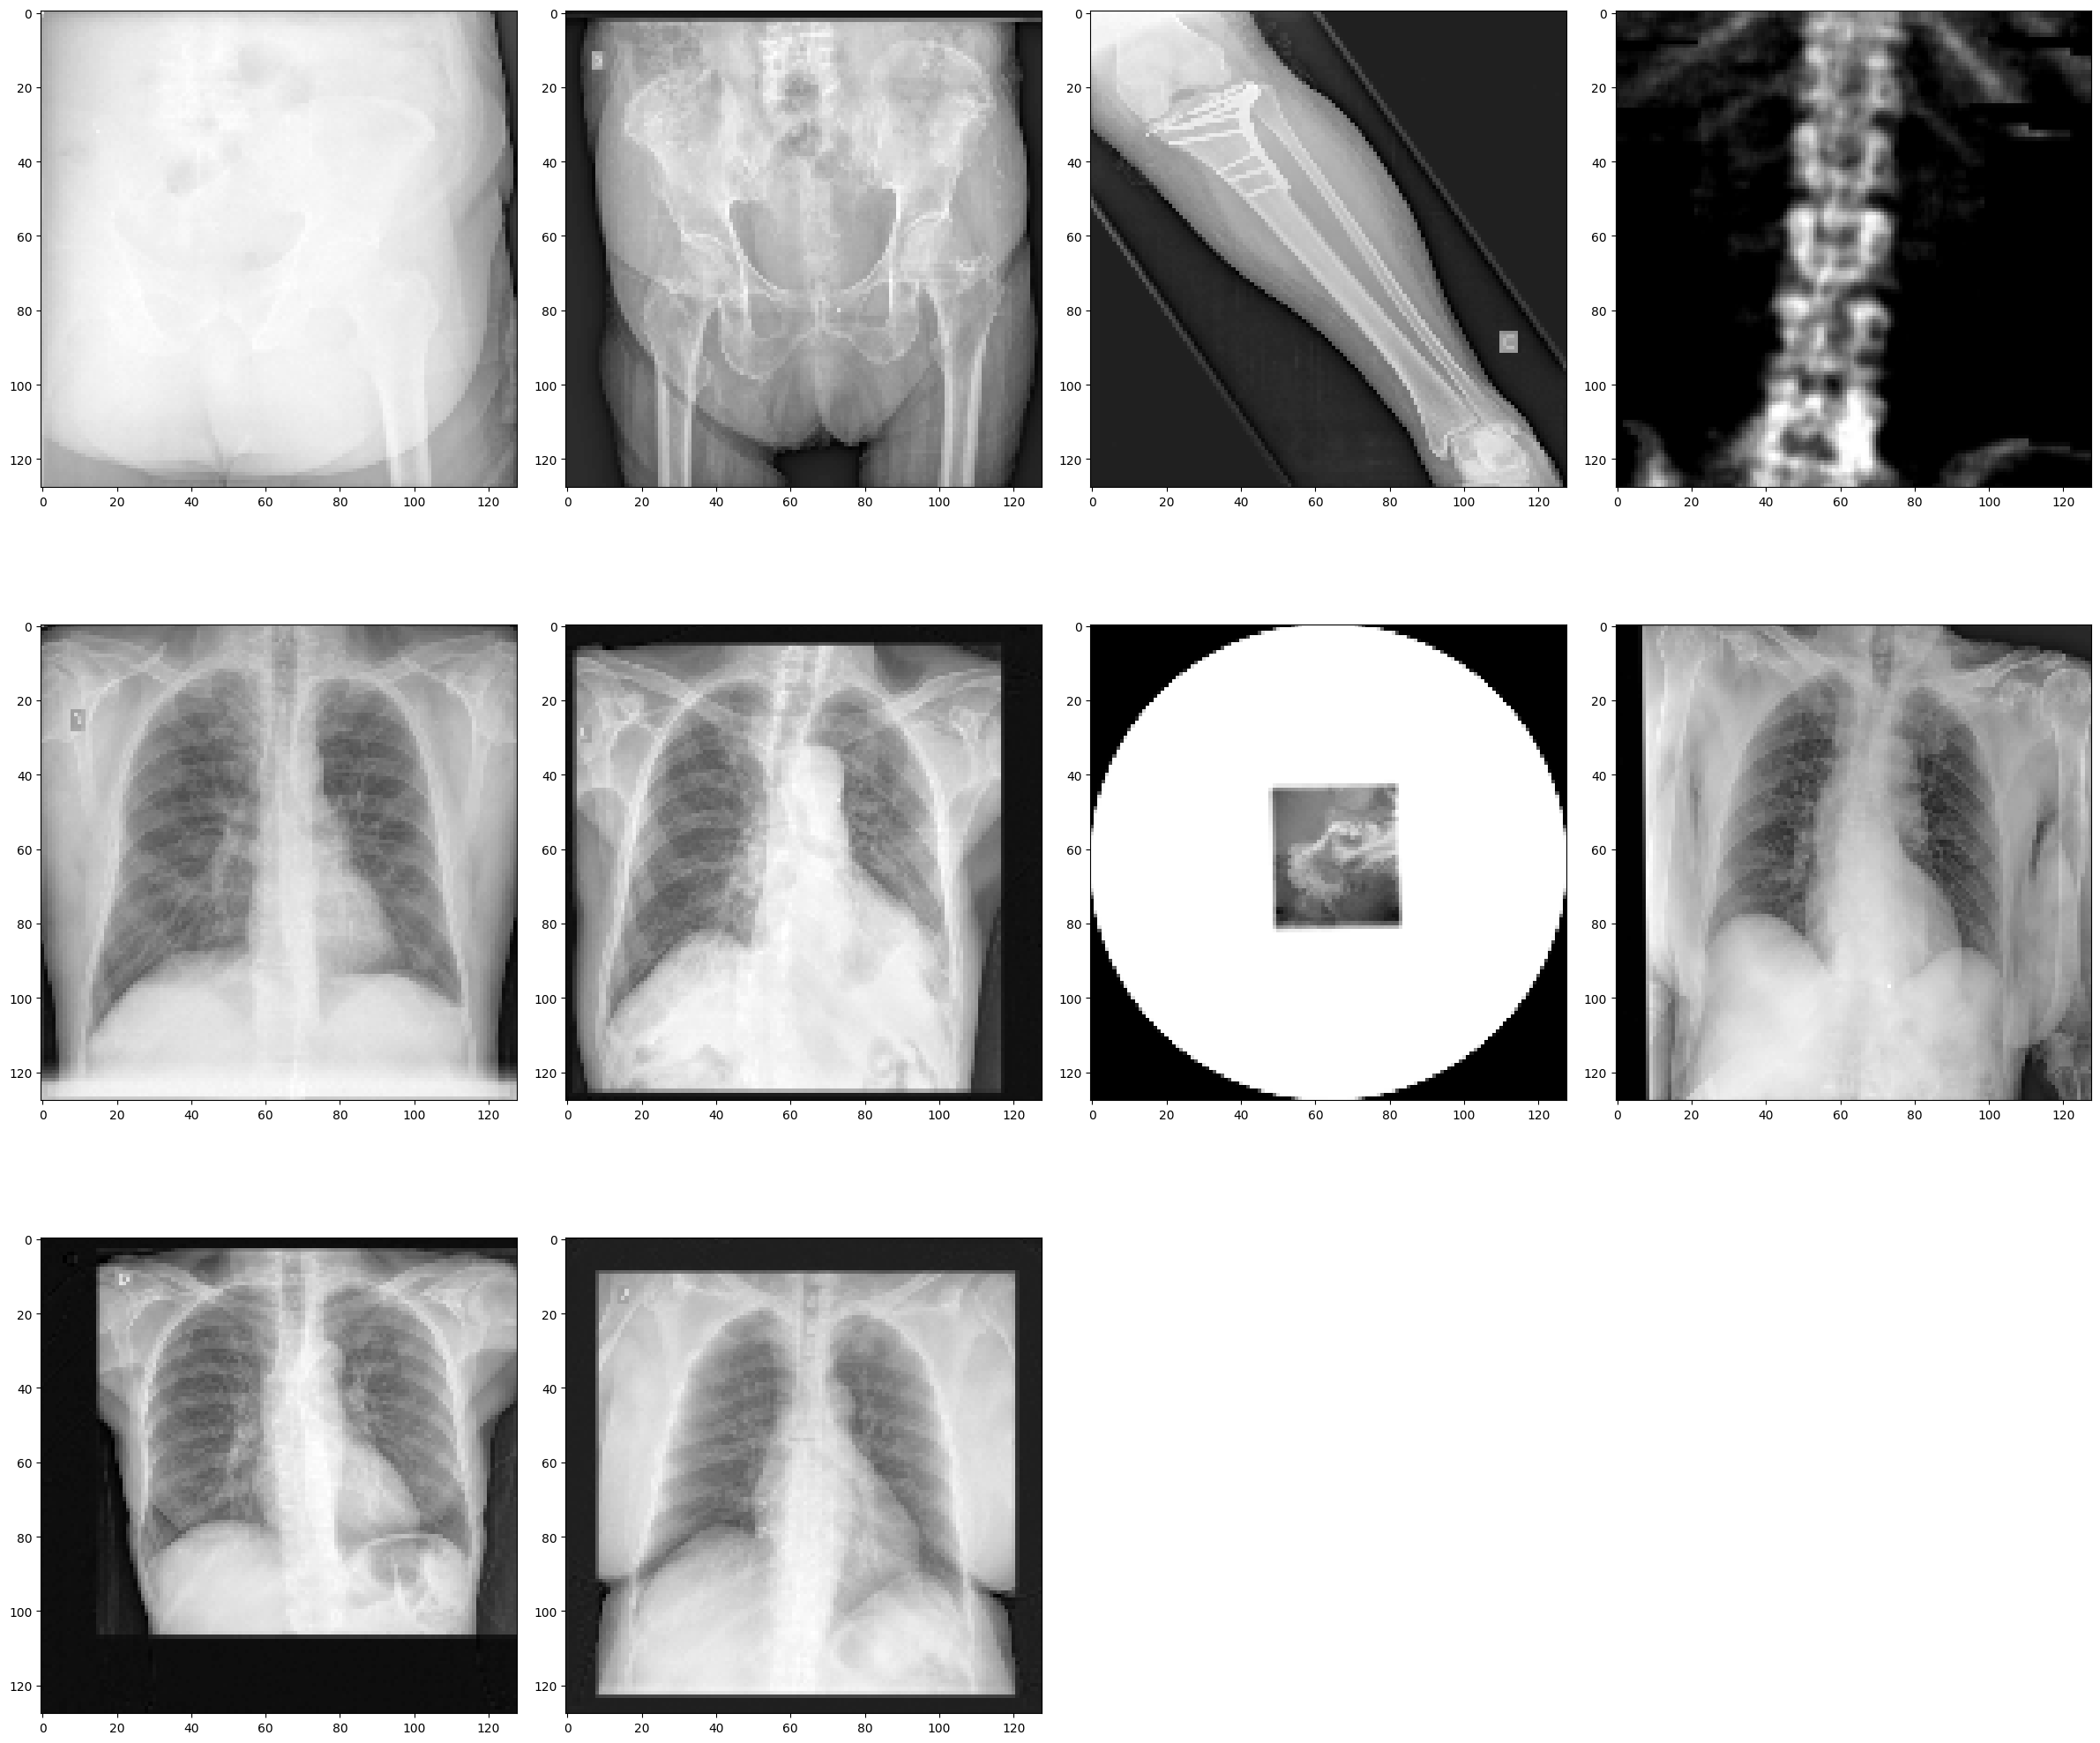

In [ ]:
# Checking how the resized images look like
fig = plt.figure(figsize=(24,28))
for i in range(10):
    plt.subplot(4,4,i+1)
    plt.imshow(X_images[i],cmap='gray')
plt.tight_layout(pad=1.4)

In [ ]:
x_images_train, x_images_test, y_labels_train, y_labels_test = train_test_split(X_images, Y_labels, test_size=0.25)

In [ ]:
y_labels_train = y_labels_train.astype(int)
y_labels_test = y_labels_test.astype(int)

CNN MODEL WITH MULTI-LAYERS
Using Convolutional Neural Network (CNN) and Keras API to desgin an image classification neutral network.

- 'Sequential' = is used to create a linear stack of layers
        model = tf.keras.models.Sequential()
        Sequential is the fundamental archetecture of neural networks. Think it as pipeline where data flows sequentially through each layer in the model. The output of one layer will become the input of the next layer. 

- 'InputLayer' = is defined to specify the input shape (128,128,1) 128x128 pixels and 1 channel for grayscale
        model.add(InputLayer(input_shape=(128,128,1)))
        While initialling the neural network especially Sequential model you should define the input shape of your data because:
        - This will initalize the weights and biases of the sebsequent layers correctly. This is needed so the network setup connections between the layers and allocate appropiate number of parameters for each layer
        - Specifing the input shape helps catch errors and inconsistancies earlier in the building process. If you try to connect a layer with the wrong input shape the framework will raise an error making it easier to debug and troubleshoot your model.

- 'Conv2D' = (CNN) layer is added for feature extraction
        model.add(Conv2D(64, kernal_size=(3,3), activation='relu', kernal_initializer='he_normal', padding='same'))
        Conv2D(CNN) parameters include 
        - '64' filters (kernals/channels): means in CNN each filter learns to detect different features in the input data 
        - 'kernal_size: this defines the filter size that slides over the input data meaning the (3x3) pixel filter will slide over the image to detect features
        - 'activation': this function help the model by allowing it to generate a non-linear output for each element in the image array. 'relu' (Rectified Linear Activation) allows non-linearity while being computationally efficent.
        - 'kenal_initialization': this defines the weight initialization techniques for filter weights. 'he_normal' is an initailization method that helps prevent vanishing gradients during training.
        - 'padding': this defines the padding strategy for input data before CNN operation. 'same' padding means that the input data will be padded with zeros in such a way that the output has the same spatial dimentions as the input. padding helps maintain the spatial dimensions of the input and output volumes after convolution.  

- 'MaxPooling2D' = (max pooling) layer is added to downsize the spatial dimensions to reduce computations
        model.add(MaxPooling2D(pool_size=(2,2)))
        'MaxPooling2D' is used in CNN to downsize the spatial dimentions (width, height) of the input data while retaining important information. This is done by retaining the maximum value from a group of neighbouring pixels in the input hence reducing the dimention of the data. '(2x2)' means that this operation takes a maximum value within each 2x2 window

- 'Dropout' = layer is added for regularization, which helps prevent overfitting by randomly setting fraction inputs to 0 during each update
        model.add(Dropout(0.6))
        Dropout layer is used to prevent overfitting in a neural network. Overfitting occurs when a model learn extremely well on the trained data but fails to generalize to new unseen data. Dropout helps improve model generalization by introducing randomness during training. At each training layer a different set of neurons is dropped out which means they are not used to compute the output of the layer. The dropout rate is the percentage of neurons that are dropped out. In this example 60% neurons in EACH layer will be randomly dropped out during training. The remaining 40% neurons will be used to compute the output of the layer.

- 'Flatten' = layer flattens the output from Conv2D into a vector (1-D vector) so that it can be processed by Dense Layers (fully connected layers)
        model.add(Flatten())
        Flatten layer reshapes the input data to one-dimentional array. This is placed at the end of the sequence of CNN layers just before the fully-connected layer Dense() in a neural network. The purpose is to flatten the input that can be fed into Dense() layer. This conversion is required because Dense() layers expect one-dimentional array as they are fully connected to establish network. For example if the CNN produces a feature map (batch_size, height, width, channels), the flatten size is the product of (height x weigth x channel) 

- 'Dense' = represent fully connected layers. These layers process the flattened features to make decisions. Layer as many units as classes in your classification problem (41 in this case). This uses the activation fucntion to output class probabilities 
        model.add(Dense(2048, activation='relu'))
        model.add(Dense(41, activation='softmax'))
        Dense layers are fully-connected layers they take input from CNN earlier layers extracted features to learn complex relationships in the data. Dense() takes in number of neurons(units) as a parameter in the Dense() layer. Each neuron will learn to capture differnet patterns and features from the input data to final class scores prediction in a classification problem. 
        - activation function 'relu' (Rectification Linear Activation) applies to the output of the neurons in the Dense() layer. ReLU is a popular choice for acitvation function because its non-linear while being computationally efficent.
        - activation function 'softmax' is usually used in the output layer of the neural networks, especially for multi-class classifications problems. The output of the softmax function defines the probalities that the input belongs to each class

- 'model.compile' = the model is compiled using 'Adam' optimizer assuming binary (0 to 1) classification and accuracy as the evaluation metric
        model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
        During model training compile is an essential function that optimizes the model performace. It basically drives a computational graph that defines how the forward and backward passes will be executed during training. It sets a stage for optimization process by specifying how the model will learn from the data and udpate its parameters to make better predictions. The graph is also crutial for CPU/GPU utilization and automatic differenciation between predictions.
        - loss function: is a mathematical function the qunatifies the difference between predicted and actual values in a model. Its measures the performace and guides the optimization process by providing feedback on how well it fits the data. 'BinaryCrossentropy' is a specific type of loss function used when dealing with binaey classification problems (where the output is a binary value like 0 to 1). It measures the difference between the predicted probabilities and actual binary labels.
        - optimizer: is responsible for updating model weights (weight are connection management between two basic units within a neural network. In CNN these are the kernal/filters i.e the matrices that you use to perform convolution in a layer) to minimze the loss function. 'Adam' (Adaptive Movement Estimation) is an optimizer in deeplearning that dynamically adjusts the learning rate during training, which helps improve training speed.
        - metrics: is used to monitor model performance during training. The 'accuracy' metric measures the propotion of corrected predicted instances out of the total instances in the dataset. It is a common metric for classification tasks.
- 'summary' = print the summary of model architecture. This displays the output shape of each layer and the number of trainable parameters
        model.summary()
        During training keras provides us the summary() function to overview the archetecture of the neural network. It displays the model layers, their output shapes and number of trainable parameters in each layer. This information is crutial to understand the structure and complexity of the model.

While adding additional CNN layers you will notice a linear increase in filter numbers. This is a common CNN archetecture choice known as pyramid. This model design strategy has been found effective for the follwing reason:
- Hierarcial Feature Learning: As we move deeper into the network we increase the filters hence allowing the network to learn features at different levels of abstraction, just like a pyramid. Small filters capture global features whereas larger filters capture more finer details

In [ ]:
# Load and preprocess the image
wrist_image_path = os.path.join(os.getcwd(), 'data', 'wrist_x_ray')
images_list = os.listdir(wrist_image_path)
image_files = [image for image in images_list if image.lower().endswith(('png'))][150:200]
wrist_image_labels = []

for image_file in image_files:
    img_path = os.path.join(wrist_image_path, image_file)
    img = plt.imread(img_path)

    # Convert grayscale to RGB
    if img.ndim == 2:
        img = np.repeat(img[..., np.newaxis], 3, axis=-1) 
    
    # Resize image input for the model and expand dimensions to create a batch of size 1
    img_resized = tf.image.resize(img, (128, 128))
    img = tf.expand_dims(img_resized, axis=0) 

    # Make predictions using the loaded model
    prediction = loaded_model.predict(img)
    predicted_class = np.argmax(prediction)
    print('Prediction class: ', predicted_class)
    print('Prediction label: ', rev_label(int(predicted_class)))
    
    wrist_image_labels.append(rev_label(int(predicted_class)))

total_images = len(wrist_image_labels)
correctly_predicted = len([labels for labels in wrist_image_labels if 'Wrist' in labels])
wrong_predicted_labels = [labels for labels in wrist_image_labels if 'Wrist' not in labels]
accuracy_percentage = (correctly_predicted / total_images) * 100

print('Total wrist images predicted:', total_images)
print('Total wrist images correctly predicted:', correctly_predicted)
print('Wrong predicted labels: ', wrong_predicted_labels)
print('Percentage accuracy:', accuracy_percentage)